# Test One for the Quantum SRNN

This is a notebook for testing the quantum SRNN.

## Import everything

Modify setting for pytorch

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
currentPath=os.getcwd()

Import matplotlib and others

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import qutip as qt

Import the classical SRNN and others

In [3]:
#Modify path for the notebooks
currentPath=os.path.join(currentPath,'..')
currentPath=os.path.join(currentPath,'src')
os.chdir(currentPath)

In [4]:
from DataGenerator.HenonMapDataGen import HenonMapDataGen
from QuantumModels.QuantumSRNNs import QuantumSRNN
from QuantumModels.QuantumSRNNs import QuantumSystemFunction
from GradientFreeOptimizers.CostFunc import GradFreeMSELoss
import GradientFreeOptimizers.Helpers as hp

## Test One

### Get the data

#### Set save path

In [5]:
savepath=os.path.join(currentPath,'..\data\HenonMap\Test')
filename='QuantumSRNNTest1.csv'

In [6]:
'''
hmap=HenonMapDataGen(savepath=savepath)
hmap(1000)
hmap.save_to_CSV(filename)
''';

#### Read the data

In [7]:
hmap=HenonMapDataGen(savepath=savepath)
hmap.read_from_CSV(filename)

In [8]:
print(hmap)

Data Info:
----------------------------------------
Data Size: 1000
Data Interval: 1
Data ParamA: 1.4, Data ParamB: 0.3
Data Bound: -1.2
Data HeavyMem: True
Data Seed:
 [0.0680497216897157, 0.0504686633640329]
----------------------------------------


#### Generate the data iter

In [9]:
testSetRatio=0.2
numStep=10
batchSize=4

In [10]:
trainIter,testIter=hmap.get_data_iter(testSetRatio,numStep,batchSize,mask=0,shuffle=False)

In [11]:
X,Y=next(iter(trainIter))
print('Train Data Size:',len(trainIter))
print('X=',torch.squeeze(X))
print('Y=',torch.squeeze(Y))

Train Data Size: 76
X= tensor([[ 0.0879,  1.2037, -1.0021, -0.0449,  0.6965,  0.3073,  1.0768, -0.5310,
          0.9283, -0.3658],
        [ 0.4340,  0.4965,  0.7851,  0.2860,  1.1210, -0.6736,  0.7011,  0.1097,
          1.1935, -0.9612],
        [ 0.6201,  0.5848,  0.7073,  0.4751,  0.8962,  0.0182,  1.2684, -1.2469,
         -0.7960, -0.2611],
        [ 1.2418, -1.1265, -0.4040,  0.4336,  0.6156,  0.5995,  0.6816,  0.5294,
          0.8120,  0.2357]])
Y= tensor([[ 1.2037, -1.0021, -0.0449,  0.6965,  0.3073,  1.0768, -0.5310,  0.9283,
         -0.3658,  1.0912],
        [ 0.4965,  0.7851,  0.2860,  1.1210, -0.6736,  0.7011,  0.1097,  1.1935,
         -0.9612,  0.0645],
        [ 0.5848,  0.7073,  0.4751,  0.8962,  0.0182,  1.2684, -1.2469, -0.7960,
         -0.2611,  0.6658],
        [-1.1265, -0.4040,  0.4336,  0.6156,  0.5995,  0.6816,  0.5294,  0.8120,
          0.2357,  1.1659]])


In [12]:
X,Y=next(iter(testIter))
print('Test Data Size:',len(testIter))
print('X=',torch.squeeze(X))
print('Y=',torch.squeeze(Y))

Test Data Size: 16
X= tensor([[ 0.7912, -0.0627,  1.2318, -1.1432, -0.4602,  0.3606,  0.6799,  0.4609,
          0.9065, -0.0122],
        [-0.9145,  0.1836,  0.6784,  0.4107,  0.9674, -0.1870,  1.2413, -1.2131,
         -0.6880, -0.0265],
        [ 0.3712,  1.0149, -0.3308,  1.1513, -0.9549,  0.0688,  0.7069,  0.3211,
          1.0678, -0.4998],
        [-0.7097,  0.6138,  0.2596,  1.0898, -0.5849,  0.8480, -0.1823,  1.2079,
         -1.0973, -0.3233]])
Y= tensor([[-0.0627,  1.2318, -1.1432, -0.4602,  0.3606,  0.6799,  0.4609,  0.9065,
         -0.0122,  1.2717],
        [ 0.1836,  0.6784,  0.4107,  0.9674, -0.1870,  1.2413, -1.2131, -0.6880,
         -0.0265,  0.7926],
        [ 1.0149, -0.3308,  1.1513, -0.9549,  0.0688,  0.7069,  0.3211,  1.0678,
         -0.4998,  0.9706],
        [ 0.6138,  0.2596,  1.0898, -0.5849,  0.8480, -0.1823,  1.2079, -1.0973,
         -0.3233,  0.5245]])


### Define the SRNN

#### Parameters

In [13]:
inputSize=outputSize=1
qubits=4

In [14]:
activation=[0,2]
inputQubits=outputQubits=[i for i in range(qubits)]
interQPairs=[[i,j] for i in range(qubits) for j in range(i+1,qubits)]
inactive=['WIn','DeltaIn','J']
print('Input Qubits:',inputQubits)
print('Output Qubits:',outputQubits)
print('InterQPairs=',interQPairs)

Input Qubits: [0, 1, 2, 3]
Output Qubits: [0, 1, 2, 3]
InterQPairs= [[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]


In [15]:
measEffect=True

#### Get neccesary functions

In [16]:
srnnTestSup=QuantumSystemFunction()

In [17]:
transform=lambda Xs:[torch.squeeze(x) for x in Xs]

In [18]:
init_rnn_state=srnnTestSup.get_init_state_fun(activation=activation)
get_params=srnnTestSup.get_get_params_fun(inputQubits=inputQubits,outputQubits=outputQubits,interQPairs=interQPairs,inactive=inactive)
rnn=srnnTestSup.get_forward_fn_fun(measEffect=measEffect)
predict_fun=srnnTestSup.get_predict_fun(outputTransoform=transform)

#### Create the SRNN

In [19]:
net=QuantumSRNN(inputSize,qubits,outputSize,get_params,init_rnn_state,rnn)

#### Test prediction

In [20]:
state=net.begin_state(batchSize)
Y,newState=net(X,state)
Y.shape, len(newState), newState[0][0].shape

(torch.Size([40, 1]), 1, (16, 16))

In [21]:
preX,preY=hmap.data_as_tensor
preX,preY=torch.unsqueeze(preX[:2],-1),torch.unsqueeze(preY[:10],-1)
print('preX=',preX)
preY=[y for y in torch.cat((preX[:2],preY[1:]),dim=0)]
print('preY=',preY)

preX= tensor([[0.0680],
        [0.0505]])
preY= [tensor([0.0680]), tensor([0.0505]), tensor([1.0168]), tensor([-0.4324]), tensor([1.0433]), tensor([-0.6535]), tensor([0.7152]), tensor([0.0879]), tensor([1.2037]), tensor([-1.0021]), tensor([-0.0449])]


In [22]:
preX=torch.unsqueeze(preX,-1)
YHat=predict_fun(preX,net,numPreds=5)
print('YHat=',YHat)

YHat= [tensor(0.0680), tensor(0.0505), tensor(-0.0018), tensor(-0.0018), tensor(-0.0018), tensor(-0.0018), tensor(-0.0018)]


### Train the network

#### Parameters

In [23]:
num_epochs, lr = 10, 0.1

#### Loss function

In [24]:
lossFunc=GradFreeMSELoss(net)

In [25]:
print(net.params)

[tensor([[ 0.0059],
        [-0.0342],
        [ 0.0031],
        [-0.0019]], requires_grad=True), tensor([0.], requires_grad=True)]


#### Trainer

In [26]:
trainer = torch.optim.SGD(net.params, lr=lr)
scheduler=torch.optim.lr_scheduler.StepLR(trainer,step_size=100,gamma=0.1)

In [27]:
print(net.params[0].is_leaf)
print(net.params[1].is_leaf)

True
True


#### Initial loss

In [28]:
l_epochs=[]
train_l=QuantumSystemFunction.evaluate_accuracy(net,trainIter,lossFunc,False)
test_l=QuantumSystemFunction.evaluate_accuracy(net,testIter,lossFunc,False)
l_epochs.append([train_l,test_l])
print('Initial Train Loss:',train_l)
print('Initial Test Loss:',test_l)

Initial Train Loss: 0.5841480656674034
Initial Test Loss: 0.5962174129486084


#### Training

TestLoss 0.534890, 32.782728 point/s
Prediction:
 [tensor(0.0680), tensor(0.0505), tensor(0.2594), tensor(0.2594), tensor(0.2594), tensor(0.2594), tensor(0.2594), tensor(0.2594), tensor(0.2594), tensor(0.2594), tensor(0.2594)]
Answer:
 [tensor([0.0680]), tensor([0.0505]), tensor([1.0168]), tensor([-0.4324]), tensor([1.0433]), tensor([-0.6535]), tensor([0.7152]), tensor([0.0879]), tensor([1.2037]), tensor([-1.0021]), tensor([-0.0449])]


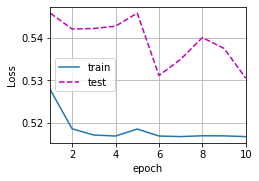

In [29]:
animator = hp.Animator(xlabel='epoch', ylabel='Loss',
                            legend=['train','test'],xlim=[1,num_epochs])
    # prediction
predict = lambda prefix: predict_fun(prefix,net, numPreds=9)
# train and predict
for epoch in range(num_epochs):
    trainLoss, speed = QuantumSystemFunction.train_epoch(
        net, trainIter, lossFunc, trainer, False)
    testLoss=QuantumSystemFunction.evaluate_accuracy(net, testIter, lossFunc, False)
    if (epoch + 1) % 1 == 0:
        print(predict(preX))
        animator.add(epoch + 1, [trainLoss,testLoss])
    l_epochs.append([trainLoss,testLoss])
    scheduler.step()
testLoss=QuantumSystemFunction.evaluate_accuracy(net, testIter, lossFunc, False)
print(f'TestLoss {testLoss:f}, {speed:f} point/s')
print('Prediction:\n',predict(preX))
print('Answer:\n',preY)

### Visualize the performance

#### One Step Prediction

In [30]:
X,Y=next(iter(testIter))
state=net.begin_state(batchSize)
Y_hat,newState=net(X,state)
print('X=',torch.squeeze(X))
print('Prediction=',torch.squeeze(Y_hat).detach())
Y=Y.transpose(0,1).reshape([-1,Y.shape[-1]])
print('Y=',torch.squeeze(Y))



X= tensor([[ 0.6799,  0.4609,  0.9065, -0.0122,  1.2717, -1.2680, -0.8693, -0.4383,
          0.4703,  0.5589],
        [ 0.9674, -0.1870,  1.2413, -1.2131, -0.6880, -0.0265,  0.7926,  0.1125,
          1.2201, -1.0503],
        [-0.3308,  1.1513, -0.9549,  0.0688,  0.7069,  0.3211,  1.0678, -0.4998,
          0.9706, -0.4688],
        [-0.7097,  0.6138,  0.2596,  1.0898, -0.5849,  0.8480, -0.1823,  1.2079,
         -1.0973, -0.3233]])
Prediction= tensor([0.2570, 0.2569, 0.2572, 0.2572, 0.2593, 0.2593, 0.2593, 0.2594, 0.2594,
        0.2594, 0.2594, 0.2594, 0.2594, 0.2594, 0.2594, 0.2594, 0.2594, 0.2594,
        0.2594, 0.2594, 0.2594, 0.2594, 0.2594, 0.2594, 0.2594, 0.2594, 0.2594,
        0.2594, 0.2594, 0.2594, 0.2594, 0.2594, 0.2594, 0.2594, 0.2594, 0.2594,
        0.2594, 0.2594, 0.2594, 0.2594])
Y= tensor([ 0.4609, -0.1870,  1.1513,  0.6138,  0.9065,  1.2413, -0.9549,  0.2596,
        -0.0122, -1.2131,  0.0688,  1.0898,  1.2717, -0.6880,  0.7069, -0.5849,
        -1.2680, -0.0265

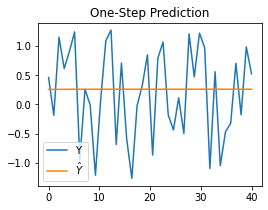

In [31]:
#Visualize the data
axes,fig=plt.subplots(1,1,figsize=(4,3))
plt.title('One-Step Prediction')
plt.plot(torch.linspace(0,Y.numel(),Y.numel()),torch.squeeze(Y),label='Y')
plt.plot(torch.linspace(0,Y.numel(),Y.numel()),torch.squeeze(Y_hat).detach(),label=r'$\hat{Y}$')
plt.legend();

#### Multi Step Prediction

In [32]:
prefixSize=10
totalSize=40
testShift=int(len(hmap)*(1-testSetRatio))

In [33]:
preX,preY=hmap.data_as_tensor
preX,preY=torch.unsqueeze(preX[testShift:testShift+prefixSize],-1),torch.unsqueeze(preY[testShift:testShift+totalSize-1],-1)
#print('preX=',preX)
preY=[y for y in torch.cat((preX[:2],preY[1:]),dim=0)]
#print('preY=',preY)
len(preY)

40

In [34]:
preX=torch.unsqueeze(preX,-1)
YHat=predict_fun(preX,net,numPreds=totalSize-prefixSize)
#print('YHat=',YHat)
len(YHat)

40

C:\ProgramData\Anaconda3\envs\d2l\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
C:\ProgramData\Anaconda3\envs\d2l\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


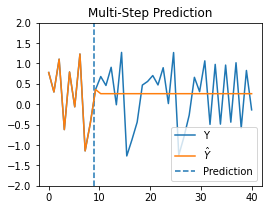

In [35]:
#Visualize the data
axes,fig=plt.subplots(1,1,figsize=(4,3))
plt.title('Multi-Step Prediction')
fig.set_ylim(-2,2)
plt.plot(torch.linspace(0,len(preY),len(preY)),preY,label='Y')
plt.plot(torch.linspace(0,len(preY),len(preY)),YHat,label=r'$\hat{Y}$')
plt.vlines([prefixSize-1],ymin=-2,ymax=2,linestyles='dashed',label='Prediction')
plt.legend();

In [36]:
print(net.params)

[tensor([[ 0.0304],
        [-0.0181],
        [ 0.0217],
        [ 0.0143]], requires_grad=True), tensor([0.2562], requires_grad=True)]


In [37]:
state=net.begin_state(batchSize)
Y,newState=net(X,state)
Y.shape, len(newState), newState[0][0].shape

(torch.Size([40, 1]), 1, (16, 16))

In [38]:
I=[]
for i in range(qubits):
    I.append(qt.qeye(2))
I=qt.tensor(I)
print(qt.expect(I,newState[0][0]))

0.9999999999999998


In [39]:
sigma=[]
j=1
for i in range(qubits):
    if i==j:
        sigma.append(qt.sigmaz())
    else:
        sigma.append(qt.qeye(2))
sigma=qt.tensor(sigma)
print(qt.expect(sigma,newState[0][0]))

0.06567365600628067


# End of the test